In [1]:
import pandas as pd
import numpy as np
#visuals
import matplotlib.pyplot as plt
import seaborn as sns
#db
import psycopg2 as psy
#for decoding the IP's location
import geoip2.database
from geopy.geocoders import Nominatim


In [2]:
Feb5 = pd.read_csv('/Users/sa12/Desktop/CybercrimeData/2023-02-05.csv')
Feb6 = pd.read_csv('/Users/sa12/Desktop/CybercrimeData/2023-02-06.csv')
Feb7 =pd.read_csv('/Users/sa12/Desktop/CybercrimeData/2023-02-07.csv')
Feb8 = pd.read_csv('/Users/sa12/Desktop/CybercrimeData/2023-02-08.csv')
Feb9 = pd.read_csv('/Users/sa12/Desktop/CybercrimeData/2023-02-09.csv')
Feb10 = pd.read_csv('/Users/sa12/Desktop/CybercrimeData/2023-02-10.csv')
Feb11 = pd.read_csv('/Users/sa12/Desktop/CybercrimeData/2023-02-11.csv')
Feb12 = pd.read_csv('/Users/sa12/Desktop/CybercrimeData/2023-02-12.csv')

In [29]:
Feb5.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1950.000000,1950.000000,1950.000000,1.950000e+03,1950.000000,1950.000000,1950.000000,1.950000e+03,1950.000000,1950.000000,...,1950.000000,1950.000000,1.950000e+03,1950.0,1.950000e+03,1.950000e+03,1.950000e+03,1.950000e+03,1.950000e+03,1.950000e+03
mean,33772.874872,982.644103,14.929744,5.095167e+06,222.395385,25.586154,1909.062564,3.428343e+04,105.253333,32.734359,...,219.676410,11.325128,6.695856e+02,0.0,6.695856e+02,6.695856e+02,1.673921e+15,2.430475e+12,1.675639e+15,1.672202e+15
std,18880.070091,5660.826587,4.300738,1.120996e+07,674.538735,1044.031339,5358.096049,1.488086e+06,271.245718,28.307521,...,672.400046,7.376132,2.391388e+04,0.0,2.391388e+04,2.391388e+04,3.791653e+13,5.362211e+13,6.244567e+08,7.583309e+13
min,22.000000,22.000000,6.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,8.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,8.378195e+14,0.000000e+00,1.675638e+15,6.007164e+06
25%,17480.000000,123.000000,17.000000,4.070000e+02,1.000000,1.000000,48.000000,4.800000e+01,31.000000,8.000000,...,0.000000,8.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.675639e+15,0.000000e+00,1.675639e+15,1.675639e+15
50%,35824.000000,123.000000,17.000000,5.290000e+02,1.000000,1.000000,48.000000,4.800000e+01,48.000000,48.000000,...,0.000000,8.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.675639e+15,0.000000e+00,1.675639e+15,1.675639e+15
75%,49768.750000,123.000000,17.000000,8.991500e+04,3.000000,1.000000,48.000000,4.800000e+01,48.000000,48.000000,...,1.000000,8.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.675639e+15,0.000000e+00,1.675639e+15,1.675639e+15
max,65529.000000,60996.000000,17.000000,4.587067e+07,3178.000000,46105.000000,25424.000000,6.571264e+07,1440.000000,856.000000,...,3177.000000,32.000000,1.024901e+06,0.0,1.024901e+06,1.024901e+06,1.675642e+15,1.184857e+15,1.675642e+15,1.675642e+15


Because this data is predictive and measures activity, a baseline of 0 can be assumed. Any activity will be measured starting from in increments above 0. Looking through the dataset, it is apparant that some columns are filled with mostly 0's. 

<Axes: xlabel='Value', ylabel='Feature'>

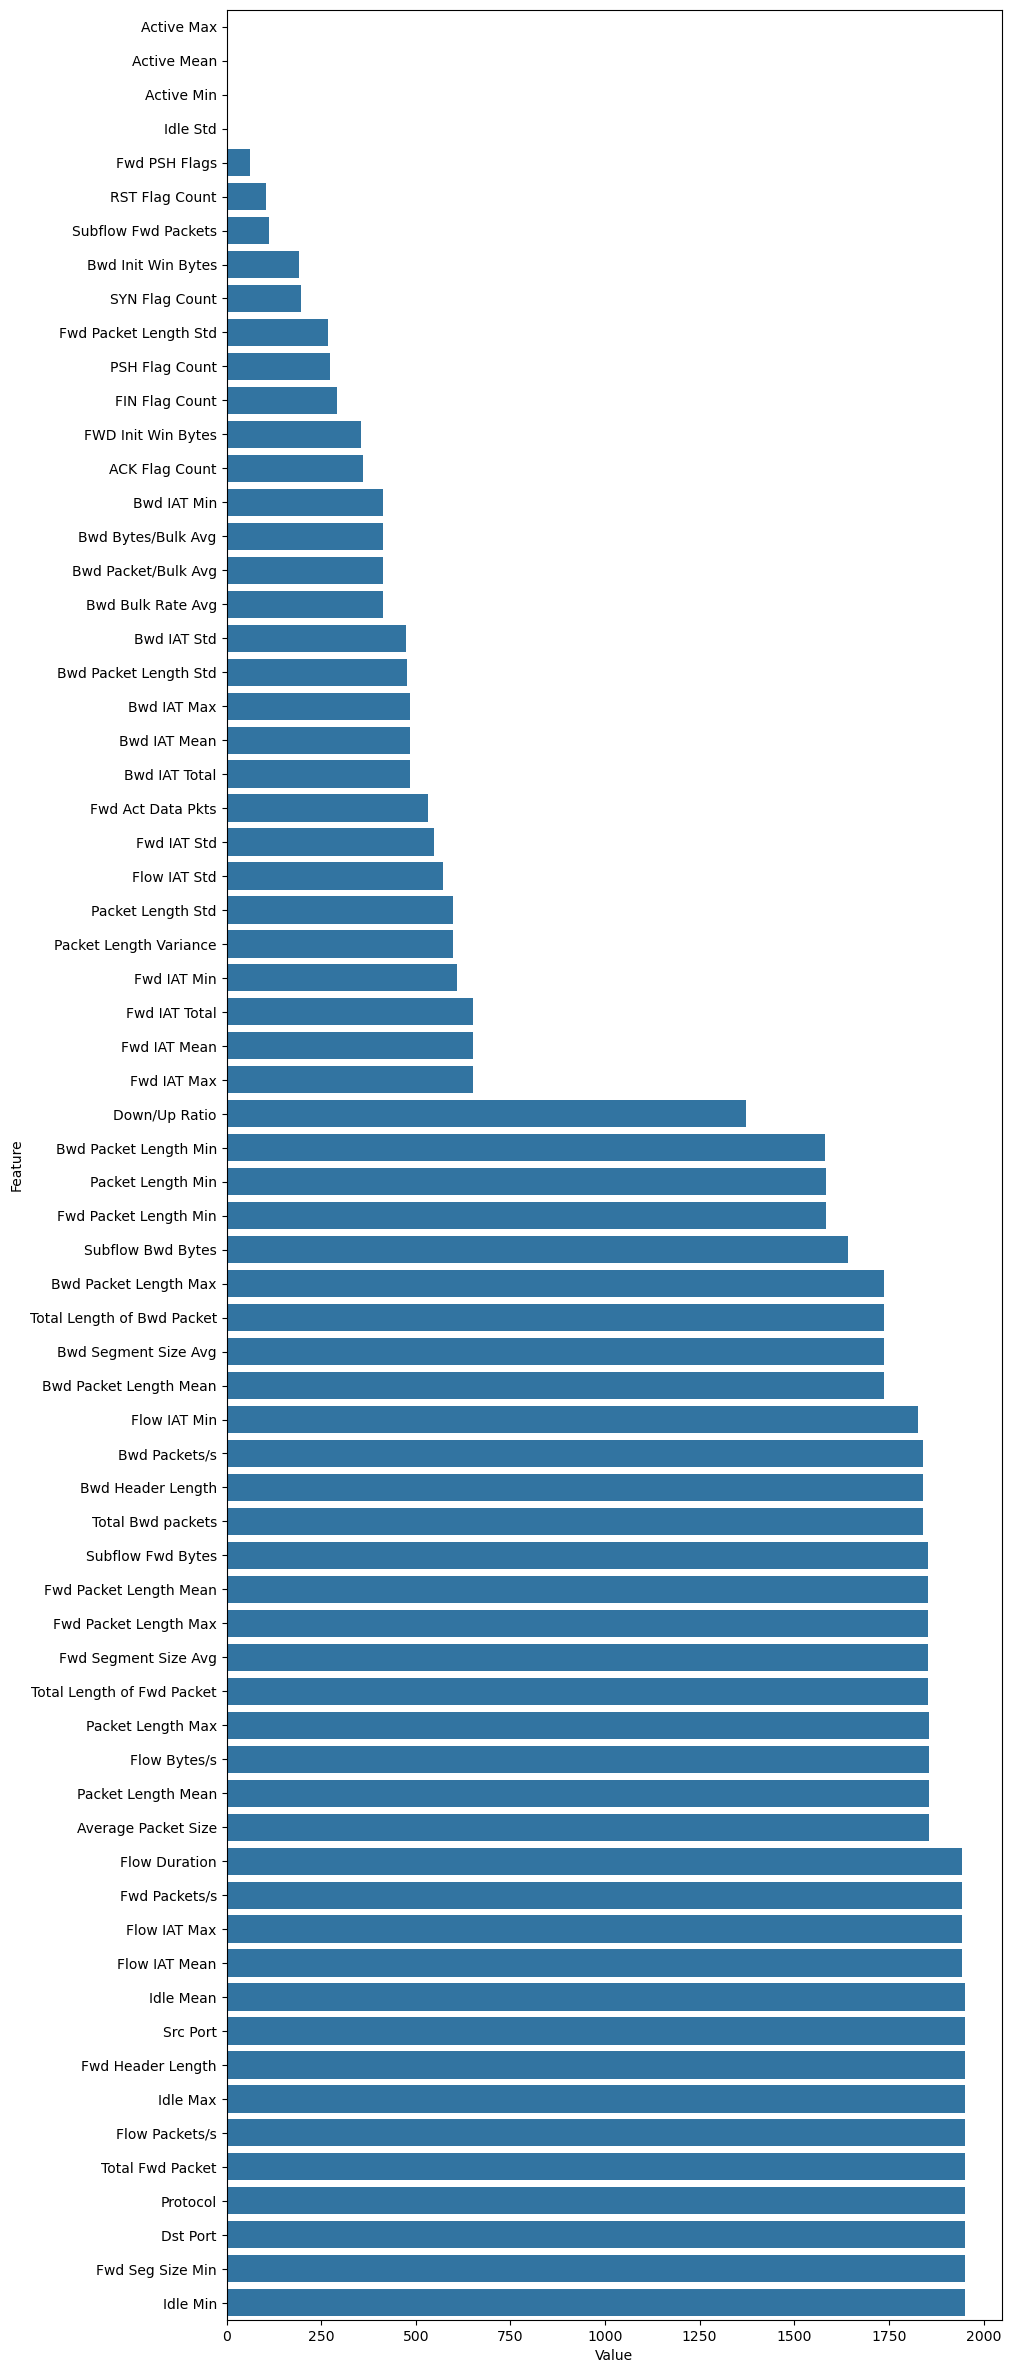

In [4]:
greater_than_zero_counts = {}
for column in Feb5.columns:
    # Check if the column is numeric to avoid errors
    if pd.api.types.is_numeric_dtype(Feb5[column]):
        count = (Feb5[column] > 0).sum()
        greater_than_zero_counts[column] = count
greater_than_zero_counts = pd.DataFrame(greater_than_zero_counts.items(), columns=['Feature', 'Value'])
greater_than_zero_counts = greater_than_zero_counts[greater_than_zero_counts['Value'] > 0].sort_values(by='Value')
plt.figure(figsize=(10,30))
sns.barplot(greater_than_zero_counts, y='Feature', x='Value')

We were able to remove 11 empty columns using this method

In [5]:
flags = Feb5[['Fwd PSH Flags', 
              'Bwd PSH Flags', 
              'Fwd URG Flags', 
              'Bwd URG Flags', 
              'FIN Flag Count', 
              'SYN Flag Count', 
              'RST Flag Count', 
              'PSH Flag Count', 
              'ACK Flag Count',
              'URG Flag Count', 
              'CWR Flag Count', 
              'ECE Flag Count', 
              'Label']]

In [6]:
flags.describe()

,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWR Flag Count,ECE Flag Count
count,1950.000000,1950.0,1950.0,1950.0,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.0,1950.0,1950.0
mean,0.031795,0.0,0.0,0.0,0.151282,0.190769,0.069744,1.067692,26.281026,0.0,0.0,0.0
std,0.175499,0.0,0.0,0.0,0.362685,0.579730,0.317535,26.715777,1104.334127,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
75%,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
max,1.000000,0.0,0.0,0.0,2.000000,3.000000,3.000000,1178.000000,48767.000000,0.0,0.0,0.0


'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWR Flag Count', & 'ECE Flag Count' all have no values and can be dropped

In [34]:
#flags = flags.drop(columns=['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags','URG Flag Count', 'CWR Flag Count', 'ECE Flag Count'])
flags.describe()

,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWR Flag Count,ECE Flag Count
count,1950.000000,1950.0,1950.0,1950.0,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.0,1950.0,1950.0
mean,0.031795,0.0,0.0,0.0,0.151282,0.190769,0.069744,1.067692,26.281026,0.0,0.0,0.0
std,0.175499,0.0,0.0,0.0,0.362685,0.579730,0.317535,26.715777,1104.334127,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
75%,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
max,1.000000,0.0,0.0,0.0,2.000000,3.000000,3.000000,1178.000000,48767.000000,0.0,0.0,0.0


In [35]:
flag_value = flags.groupby('Label')[]

SyntaxError: invalid syntax (3650627271.py, line 1)

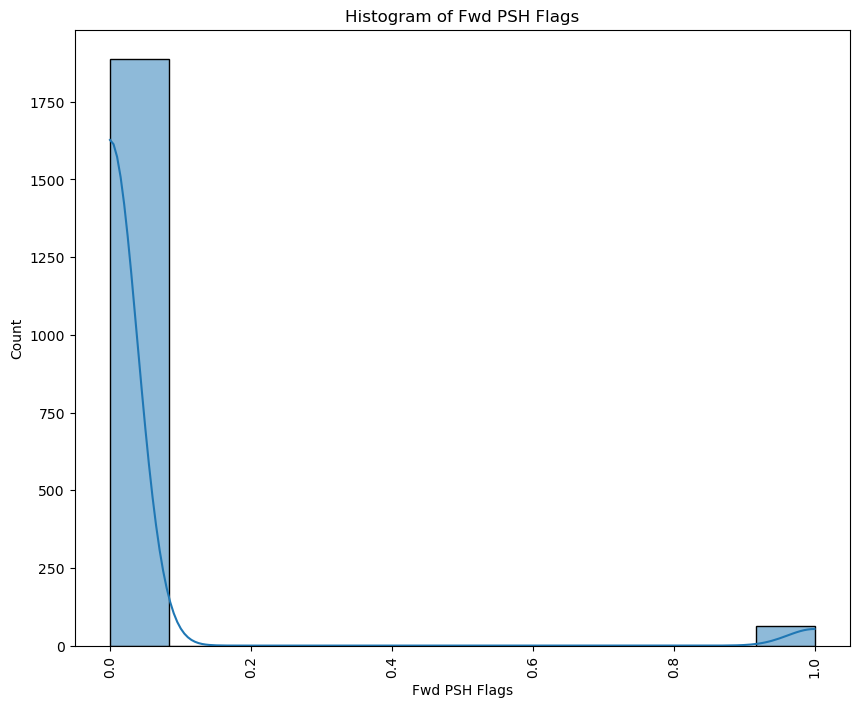

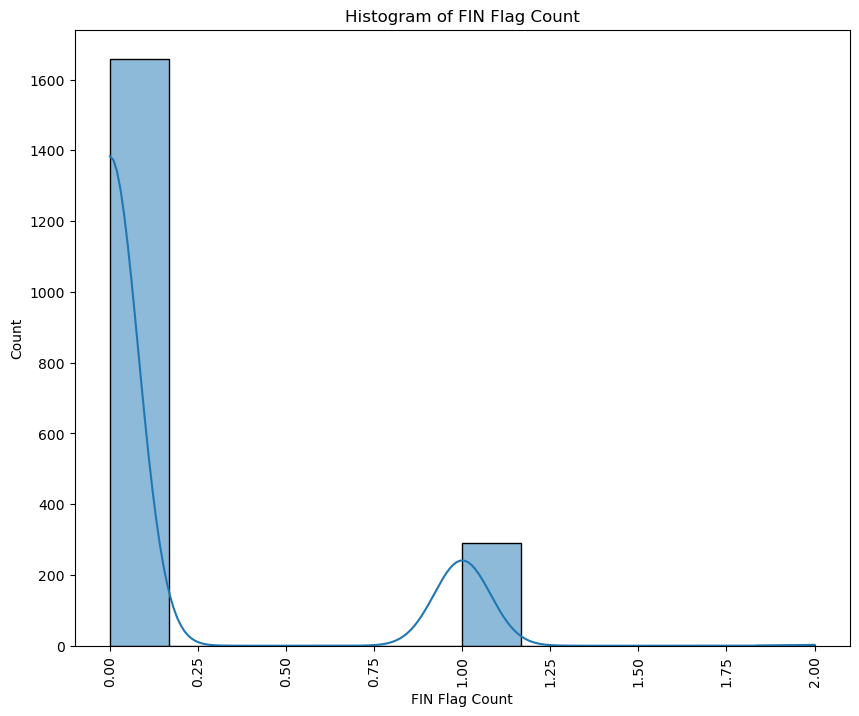

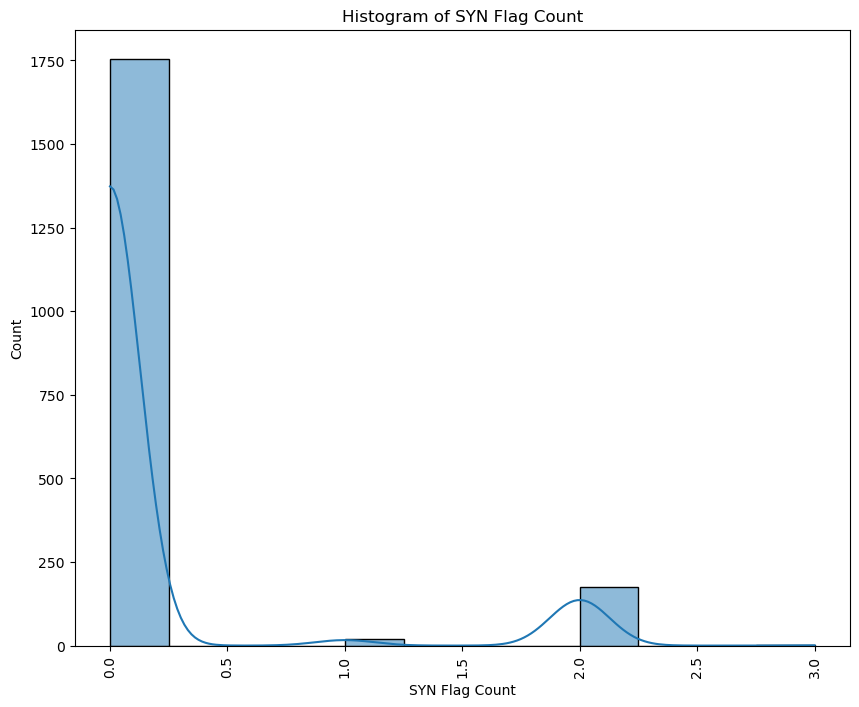

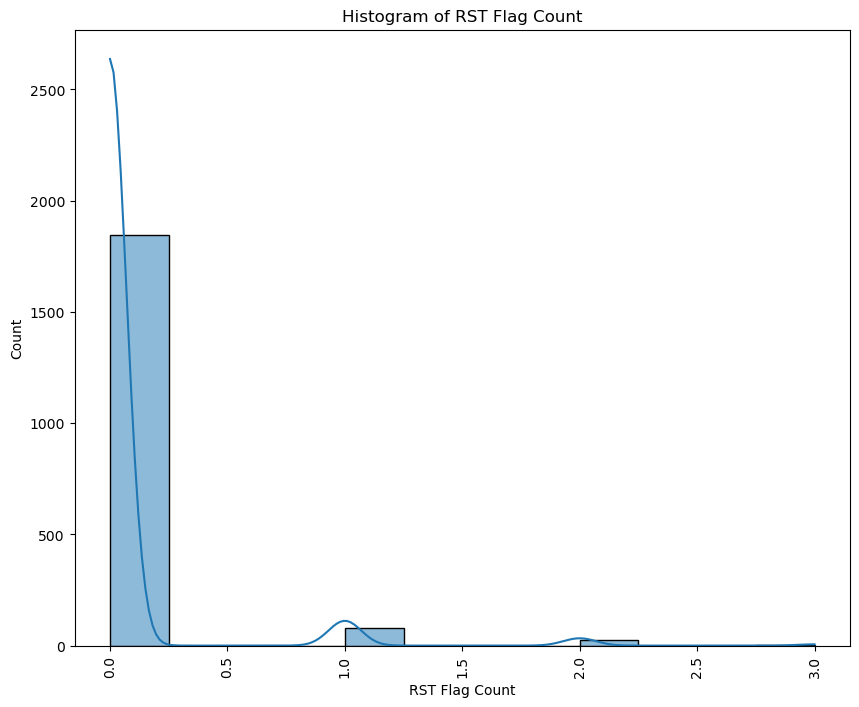

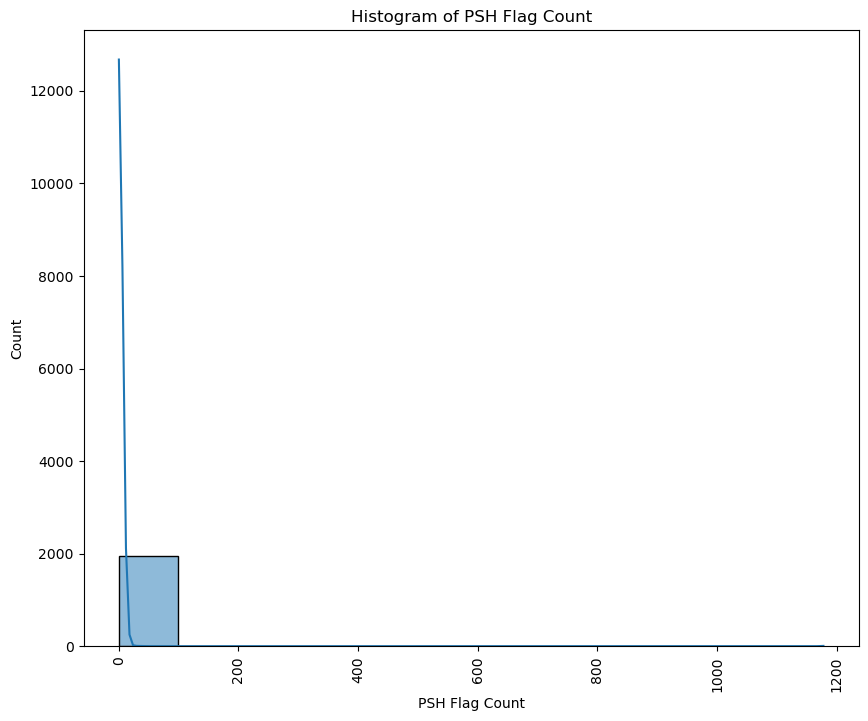

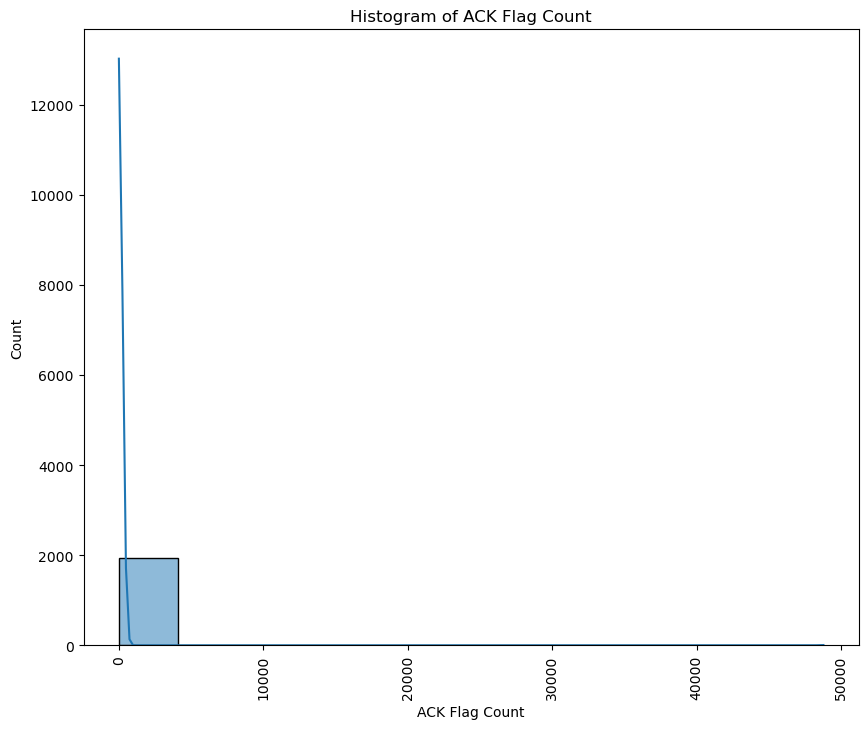

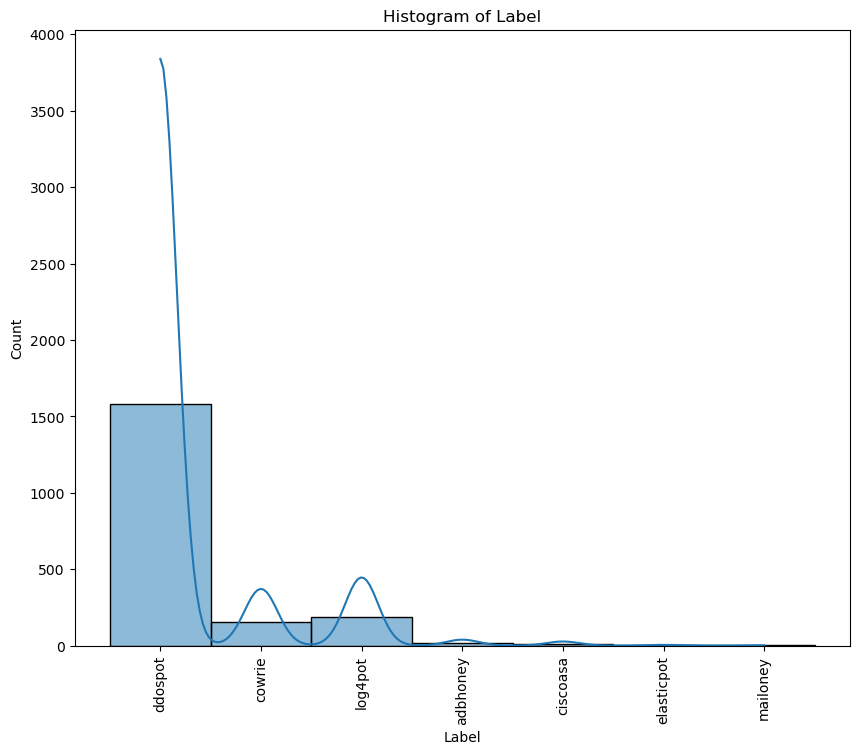

In [ ]:

for feature in flags:
    plt.figure(figsize=(10, 8))
    sns.histplot(data=flags, x=feature, kde=True)
    plt.xlabel(feature)
    plt.xticks(rotation=90)
    plt.ylabel('Count')
    plt.title(f'Histogram of {feature}')
    plt.show()

In [7]:
Feb5_Fwd = Feb5[['Total Fwd Packet',
                'Total Length of Fwd Packet',
                'Fwd Packet Length Max', 
                'Fwd Packet Length Min', 
                'Fwd Packet Length Mean', 
                'Fwd Packet Length Std', 
                'Fwd PSH Flags',  
                'Fwd Header Length', 
                'Fwd Packets/s', 
                'Fwd Segment Size Avg', 
                'Subflow Fwd Packets', 
                'Subflow Fwd Bytes', 
                'FWD Init Win Bytes', 
                'Fwd Act Data Pkts', 
                'Fwd Seg Size Min', 
                'Label']]
Feb5_Fwd.describe()

,Total Fwd Packet,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Fwd PSH Flags,Fwd Header Length,Fwd Packets/s,Fwd Segment Size Avg,Subflow Fwd Packets,Subflow Fwd Bytes,FWD Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min
count,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1.950000e+03,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000
mean,222.395385,1909.062564,105.253333,32.734359,50.790028,31.262680,0.031795,1828.010256,3.805991e+03,50.790028,0.056923,28.332821,4625.787692,219.676410,11.325128
std,674.538735,5358.096049,271.245718,28.307521,64.963692,115.899774,0.175499,5721.618442,4.648845e+04,64.963692,0.231755,42.570094,15154.864214,672.400046,7.376132
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
25%,1.000000,48.000000,31.000000,8.000000,15.500000,0.000000,0.000000,8.000000,1.055694e+02,15.500000,0.000000,12.000000,0.000000,0.000000,8.000000
50%,1.000000,48.000000,48.000000,48.000000,48.000000,0.000000,0.000000,8.000000,1.924930e+03,48.000000,0.000000,24.000000,0.000000,0.000000,8.000000
75%,3.000000,48.000000,48.000000,48.000000,48.000000,0.000000,0.000000,96.000000,2.486019e+03,48.000000,0.000000,24.000000,0.000000,1.000000,8.000000
max,3178.000000,25424.000000,1440.000000,856.000000,856.000000,655.547804,1.000000,88544.000000,2.000000e+06,856.000000,1.000000,440.000000,65535.000000,3177.000000,32.000000


In [8]:
fwd_greater_than_zero_counts = {}
for column in Feb5_Fwd.columns:
    # Check if the column is numeric to avoid errors
    if pd.api.types.is_numeric_dtype(Feb5_Fwd[column]):
        count = (Feb5_Fwd[column] > 0).sum()
        fwd_greater_than_zero_counts[column] = count
fwd_greater_than_zero_counts

{'Total Fwd Packet': 1950,
 'Total Length of Fwd Packet': 1853,
 'Fwd Packet Length Max': 1853,
 'Fwd Packet Length Min': 1584,
 'Fwd Packet Length Mean': 1853,
 'Fwd Packet Length Std': 269,
 'Fwd PSH Flags': 62,
 'Fwd Header Length': 1950,
 'Fwd Packets/s': 1943,
 'Fwd Segment Size Avg': 1853,
 'Subflow Fwd Packets': 111,
 'Subflow Fwd Bytes': 1852,
 'FWD Init Win Bytes': 354,
 'Fwd Act Data Pkts': 533,
 'Fwd Seg Size Min': 1950}

In [9]:
Feb5_Bwd = Feb5[['Total Bwd packets', 
      'Total Length of Bwd Packet', 
      'Bwd Packet Length Max', 
      'Bwd Packet Length Min', 
      'Bwd Packet Length Mean', 
      'Bwd Packet Length Std',   
      'Bwd Header Length',
      'Bwd Packets/s', 
      'Bwd Segment Size Avg', 
      'Bwd Bytes/Bulk Avg', 
      'Bwd Packet/Bulk Avg', 
      'Bwd Bulk Rate Avg', 
      'Subflow Bwd Bytes', 
      'Bwd Init Win Bytes', 
      'Label']]
Feb5_Bwd.describe()

,Total Bwd packets,Total Length of Bwd Packet,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Bwd Header Length,Bwd Packets/s,Bwd Segment Size Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Bwd Bytes,Bwd Init Win Bytes
count,1950.000000,1.950000e+03,1950.000000,1950.000000,1950.000000,1950.000000,1.950000e+03,1950.000000,1950.000000,1.950000e+03,1950.000000,1.950000e+03,1950.000000,1950.000000
mean,25.586154,3.428343e+04,171.240000,80.348718,123.711475,44.820342,7.839303e+02,1670.284933,123.711475,3.609990e+04,244.381538,1.299048e+05,32.793846,1049.616410
std,1044.031339,1.488086e+06,308.136576,98.444221,176.718653,136.850507,3.340995e+04,3133.496812,176.718653,1.488083e+06,1238.327904,3.600413e+06,87.086003,7380.336626
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,1.000000,4.800000e+01,48.000000,48.000000,48.000000,0.000000,8.000000e+00,9.161733,48.000000,0.000000e+00,0.000000,0.000000e+00,2.000000,0.000000
50%,1.000000,4.800000e+01,48.000000,48.000000,48.000000,0.000000,8.000000e+00,1780.945312,48.000000,0.000000e+00,0.000000,0.000000e+00,24.000000,0.000000
75%,1.000000,4.800000e+01,48.000000,48.000000,48.000000,0.000000,3.200000e+01,2375.296912,48.000000,0.000000e+00,0.000000,0.000000e+00,24.000000,0.000000
max,46105.000000,6.571264e+07,1448.000000,440.000000,1425.282269,745.359198,1.475368e+06,105856.367798,1425.282269,6.571380e+07,46104.000000,1.570219e+08,1347.000000,65160.000000


1841    105856.367798
1843     37037.037037
1527     32608.695652
1911     28571.428571
1732     25000.000000
            ...      
1449      2923.976608
1435      2915.451895
947       2915.451895
1411      2915.451895
958       2915.451895
Name: Bwd Packets/s, Length: 100, dtype: float64

In [ ]:
bwd_greater_than_zero_counts = {}
for column in Feb5_Bwd.columns:
    # Check if the column is numeric to avoid errors
    if pd.api.types.is_numeric_dtype(Feb5_Bwd[column]):
        count = (Feb5_Bwd[column] > 0).sum()
        bwd_greater_than_zero_counts[column] = count

In [ ]:
bwd_greater_than_zero_counts

{'Total Bwd packets': 1839,
 'Total Length of Bwd Packet': 1736,
 'Bwd Packet Length Max': 1736,
 'Bwd Packet Length Min': 1582,
 'Bwd Packet Length Mean': 1736,
 'Bwd Packet Length Std': 478,
 'Bwd Header Length': 1839,
 'Bwd Packets/s': 1839,
 'Bwd Segment Size Avg': 1736,
 'Bwd Bytes/Bulk Avg': 414,
 'Bwd Packet/Bulk Avg': 414,
 'Bwd Bulk Rate Avg': 414,
 'Subflow Bwd Bytes': 1641,
 'Bwd Init Win Bytes': 192}

In [ ]:
Feb5_IAD = Feb5[['Flow IAT Mean', 
                 'Flow IAT Std', 
                 'Flow IAT Max', 
                 'Flow IAT Min', 
                 'Fwd IAT Total', 
                 'Fwd IAT Mean', 
                 'Fwd IAT Std', 
                 'Fwd IAT Max', 
                 'Fwd IAT Min', 
                 'Bwd IAT Total', 
                 'Bwd IAT Mean', 
                 'Bwd IAT Std',
                 'Bwd IAT Max', 
                 'Bwd IAT Min', 
                 'Active Mean',  
                 'Active Max', 
                 'Active Min', 
                 'Idle Mean', 
                 'Idle Std', 
                 'Idle Max', 
                 'Idle Min', 
                 'Label']]
Feb5_IAD.describe()

,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,...,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Active Mean,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.950000e+03,1.950000e+03,1.950000e+03,1.950000e+03,1.950000e+03,1.950000e+03,1.950000e+03,1.950000e+03,1950.000000,1.950000e+03,...,1.950000e+03,1.950000e+03,1950.000000,1.950000e+03,1.950000e+03,1.950000e+03,1.950000e+03,1.950000e+03,1.950000e+03,1.950000e+03
mean,3.549957e+04,2.794215e+04,1.285999e+05,1.954272e+04,5.073203e+06,2.912792e+04,3.403631e+04,1.092953e+05,6594.766154,6.728627e+04,...,2.958537e+04,5.493384e+04,217.088205,6.695856e+02,6.695856e+02,6.695856e+02,1.673921e+15,2.430475e+12,1.675639e+15,1.672202e+15
std,6.906652e+05,3.212160e+05,1.286211e+06,6.807799e+05,1.119854e+07,2.033871e+05,4.147909e+05,1.087556e+06,62351.527850,3.269811e+05,...,9.402505e+04,1.902176e+05,5391.643300,2.391388e+04,2.391388e+04,2.391388e+04,3.791653e+13,5.362211e+13,6.244567e+08,7.583309e+13
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.378195e+14,0.000000e+00,1.675638e+15,6.007164e+06
25%,4.020000e+02,0.000000e+00,4.060000e+02,1.520000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.675639e+15,0.000000e+00,1.675639e+15,1.675639e+15
50%,5.185000e+02,0.000000e+00,5.260000e+02,4.010000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.675639e+15,0.000000e+00,1.675639e+15,1.675639e+15
75%,7.447397e+03,3.307107e+03,3.056825e+04,5.110000e+02,6.547100e+04,9.465601e+03,1.504399e+03,2.797975e+04,126.750000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.675639e+15,0.000000e+00,1.675639e+15,1.675639e+15
max,2.995726e+07,1.225161e+07,4.584344e+07,2.995726e+07,4.587067e+07,5.733833e+06,1.620673e+07,4.584344e+07,960262.000000,1.037002e+07,...,2.497103e+06,5.000486e+06,229258.000000,1.024901e+06,1.024901e+06,1.024901e+06,1.675642e+15,1.184857e+15,1.675642e+15,1.675642e+15


In [ ]:
iad_greater_than_zero_counts = {}
for column in Feb5_IAD.columns:
    # Check if the column is numeric to avoid errors
    if pd.api.types.is_numeric_dtype(Feb5_IAD[column]):
        count = (Feb5_IAD[column] > 0).sum()
        iad_greater_than_zero_counts[column] = count
iad_greater_than_zero_counts

{'Flow IAT Mean': 1943,
 'Flow IAT Std': 573,
 'Flow IAT Max': 1943,
 'Flow IAT Min': 1827,
 'Fwd IAT Total': 651,
 'Fwd IAT Mean': 651,
 'Fwd IAT Std': 547,
 'Fwd IAT Max': 651,
 'Fwd IAT Min': 608,
 'Bwd IAT Total': 485,
 'Bwd IAT Mean': 485,
 'Bwd IAT Std': 474,
 'Bwd IAT Max': 485,
 'Bwd IAT Min': 413,
 'Active Mean': 3,
 'Active Max': 3,
 'Active Min': 3,
 'Idle Mean': 1950,
 'Idle Std': 4,
 'Idle Max': 1950,
 'Idle Min': 1950}

In [10]:
Feb5_Misc = Feb5[['Flow ID', 
                  'Src IP', 
                  'Src Port', 
                  'Dst IP', 
                  'Dst Port', 
                  'Protocol', 
                  'Timestamp', 
                  'Flow Duration', 
                  'Flow Bytes/s', 
                  'Flow Packets/s', 
                  'Packet Length Min', 
                  'Packet Length Max', 
                  'Packet Length Mean', 
                  'Packet Length Std', 
                  'Packet Length Variance', 
                  'Down/Up Ratio', 
                  'Average Packet Size',
                  'Label']]

In [11]:
reader = geoip2.database.Reader('/Users/sa12/Downloads/GeoLite2-City.mmdb')
# Build location info
locations = []

for ip in Feb5['Src IP']:
    try:
        response = reader.city(ip)

        city = response.city.name or "Unknown City"
        region = response.subdivisions.most_specific.name or "Unknown Region"
        country = response.country.name or "Unknown Country"
        lat = response.location.latitude
        lon = response.location.longitude

        location_str = f"{city}, {region}, {country} ({lat}, {lon})"
    except Exception as e:
        location_str = f"Error: {e}"

    locations.append(location_str)

# Add to DataFrame
Feb5['Location'] = locations
Feb5

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/sa12/Downloads/GeoLite2-City.mmdb'

In [ ]:
Feb5['Location'].value_counts()

Location
Unknown City, Unknown Region, United States (37.751, -97.822)    311
Unknown City, Unknown Region, China (34.7732, 113.722)           203
Error: The address 10.1.0.4 is not in the database.              163
Hong Kong, Unknown Region, Hong Kong (22.2842, 114.1759)         136
Unknown City, Unknown Region, Hong Kong (22.2578, 114.1657)      112
                                                                ... 
Osasco, São Paulo, Brazil (-23.5215, -46.7873)                     1
Joplin, Missouri, United States (37.0494, -94.5069)                1
Calahorra, La Rioja, Spain (42.3004, -1.9667)                      1
Gothenburg, Västra Götaland County, Sweden (57.7065, 11.967)       1
Amsterdam, North Holland, The Netherlands (52.3463, 4.8208)        1
Name: count, Length: 629, dtype: int64

In [ ]:
misc_greater_than_zero_counts = {}
for column in Feb5_Misc.columns:
    # Check if the column is numeric to avoid errors
    if pd.api.types.is_numeric_dtype(Feb5_Misc[column]):
        count = (Feb5_Misc[column] > 0).sum()
        misc_greater_than_zero_counts[column] = count
misc_greater_than_zero_counts

{'Src Port': 1950,
 'Dst Port': 1950,
 'Protocol': 1950,
 'Flow Duration': 1943,
 'Flow Bytes/s': 1856,
 'Flow Packets/s': 1950,
 'Packet Length Min': 1583,
 'Packet Length Max': 1856,
 'Packet Length Mean': 1856,
 'Packet Length Std': 598,
 'Packet Length Variance': 598,
 'Down/Up Ratio': 1373,
 'Average Packet Size': 1856}

In [ ]:
print(Feb5_Misc['Down/Up Ratio'].sort_values())

0        0.0
1619     0.0
1620     0.0
1621     0.0
1622     0.0
        ... 
1596     4.0
1795     4.0
99       4.0
1935     4.0
1841    17.0
Name: Down/Up Ratio, Length: 1950, dtype: float64
